In [1]:
import polars as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:

train_log = pl.read_parquet("../data/train_log.parquet")
test_log = pl.read_parquet("../data/test_log.parquet")
train_label = pl.read_parquet("../data/train_label_cv.parquet")
yado_df = pl.read_parquet("../data/yado.parquet")

In [55]:
# for area_group in ["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]:
log = train_log
log_count = log.group_by("session_id").count().filter(pl.col("count") >0)
coappear = (log
           .filter(pl.col("session_id")
                   .is_in(log_count["session_id"]))
           .pivot(index="session_id", columns="seq_no", values="yad_no")
            .join(train_label, on="session_id")
            .to_numpy()
          )

In [59]:
train_data = [[a for a in sess if not np.isnan(a)] for sess in coappear[:, 1:-1]]
fold = coappear[:, -1]
train_data = [[int(a) for a in set(sess)] for sess in train_data if len(set(sess)) > 1]

In [60]:
train_data

[[2395, 4101],
 [8253, 13535],
 [123, 4863],
 [8475, 1652],
 [96, 898],
 [6868, 4823],
 [8602, 10378],
 [13106, 10362],
 [1227, 12062],
 [4866, 175],
 [1209, 2043],
 [756, 8822],
 [13754, 7614],
 [3848, 7561],
 [7913, 143],
 [2220, 13678],
 [569, 7246],
 [7641, 7062],
 [7394, 10620],
 [2441, 13106],
 [4985, 3228],
 [7600, 1383],
 [2452, 11796],
 [11234, 9549],
 [8833, 8322],
 [13770, 8567],
 [4177, 13555],
 [7920, 3079],
 [6001, 5583],
 [9163, 13700],
 [712, 6787],
 [13776, 12125],
 [10483, 6333],
 [10834, 635],
 [9020, 11125],
 [13728, 10749],
 [11037, 2927],
 [12211, 3238],
 [13579, 10923],
 [11237, 12862],
 [13120, 7725],
 [9859, 9419],
 [7178, 12843],
 [1448, 4885],
 [8346, 12333],
 [11273, 12707],
 [7123, 2278],
 [1024, 2753, 2222],
 [5710, 10006],
 [618, 1199],
 [6441, 307],
 [9290, 4323],
 [1092, 7694, 13079],
 [13537, 3901],
 [3424, 3404],
 [9515, 13463],
 [1882, 11022],
 [8876, 4406],
 [9544, 9015],
 [3422, 11919],
 [5753, 8482],
 [12464, 1068],
 [10293, 966],
 [5241, 11499],


In [64]:
fold_model = []
from gensim.models import word2vec
for f in range(5):
    train_fold = [t for j, t in enumerate(train_data) if fold[j] != f]
    model = word2vec.Word2Vec(train_fold, vector_size=10, window=10, epochs=1000, 
                              # sample=0.000001,
                              seed=42, 
                              # ns_exponent=0.2, 
                              # negative=10,
                              # min_count=2,
                              shrink_windows=False
                             )
    
    fold_model.append(model)

In [65]:
fold_model

In [77]:
import pickle 
with open("../data/item2vec/yad2vec_models.pickle", "wb") as f:
    pickle.dump(fold_model, f)

In [69]:

yad_nos = yado_df.unique("yad_no")["yad_no"]
embbed = [{yad_no: fold_model[f].wv[yad_no] for yad_no in yad_nos.to_list() if yad_no in fold_model[f].wv} for f in range(5)]
emb_stack = np.concatenate([np.stack(list(emb.values()), axis=0) for emb in embbed], axis=0)
emb_yad = np.concatenate([list(emb.keys()) for emb in embbed], axis=0)
emb_fold = np.concatenate([[i] * len(emb) for i, emb in enumerate(embbed)])

data_dict = {
    "yad_no": emb_yad,
    "fold": emb_fold,
}
for i  in range(10):
    data_dict[f"area_emb_{i+1}"] = emb_stack[:, i]


emb_pl = pl.DataFrame(data_dict)


In [78]:
emb_pl.write_parquet("../data/item2vec/yad2vec_embs.parquet")

In [75]:
emb_pl.group_by("yad_no")

In [68]:
emb_pl.filter(pl.col("yad_no") == 96)

yad_no,fold,area_emb_1,area_emb_2,area_emb_3,area_emb_4,area_emb_5
i64,i64,f32,f32,f32,f32,f32
96,0,-1.635135,3.572837,-1.538714,4.417451,4.874539
96,1,1.724632,-0.358154,-0.842995,5.083264,5.135795
96,2,-0.519765,-3.197892,-3.166934,2.641303,4.783058
96,3,-2.574487,-0.335234,-2.012073,3.078116,5.279955
96,4,-4.250739,0.434168,0.735095,-1.166161,4.725041


In [42]:
def session_length_each_yad(log, ):

    unique_yad = log["yad_no"].unique().to_list()
    session_len = log.group_by("session_id").count()

    mean_length = []
    var_length = []
    for yad in tqdm(unique_yad):
        length = session_len.filter(pl.col("session_id").is_in(log.filter(pl.col("yad_no") == yad)["session_id"].unique().to_list()))["count"]
        mean_length.append(length.mean())
        var_length.append(length.var())

    result =  pl.DataFrame({
        "yad_no": unique_yad,
        "sess_length_mean_yad": mean_length,
        "sess_length_var_yad": var_length
    })

    result = result.with_columns([
        pl.col("sess_length_mean_yad").cast(pl.Float32),
        pl.col("sess_length_var_yad").cast(pl.Float32),
    ])

    return result
    


session_length_yad_feature = session_length_each_yad(pl.concat([train_log, test_log]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13562/13562 [02:02<00:00, 110.91it/s]


In [43]:
print(session_length_yad_feature)

shape: (13_562, 3)
┌────────┬──────────────────────┬─────────────────────┐
│ yad_no ┆ sess_length_mean_yad ┆ sess_length_var_yad │
│ ---    ┆ ---                  ┆ ---                 │
│ i64    ┆ f32                  ┆ f32                 │
╞════════╪══════════════════════╪═════════════════════╡
│ 1      ┆ 1.333333             ┆ 0.229885            │
│ 2      ┆ 1.241379             ┆ 0.189655            │
│ 3      ┆ 1.802083             ┆ 0.693608            │
│ 4      ┆ 1.809524             ┆ 0.576037            │
│ …      ┆ …                    ┆ …                   │
│ 13803  ┆ 1.368421             ┆ 0.401138            │
│ 13804  ┆ 1.569767             ┆ 0.483311            │
│ 13805  ┆ 1.5                  ┆ 0.333333            │
│ 13806  ┆ 1.675676             ┆ 0.614114            │
└────────┴──────────────────────┴─────────────────────┘


(array([6.831e+03, 4.430e+03, 1.159e+03, 2.950e+02, 7.700e+01, 3.400e+01,
        1.600e+01, 6.000e+00, 1.000e+00, 2.000e+00]),
 array([0.        , 0.30833334, 0.61666667, 0.92499995, 1.23333335,
        1.54166663, 1.8499999 , 2.1583333 , 2.4666667 , 2.77499986,
        3.08333325]),
 <BarContainer object of 10 artists>)

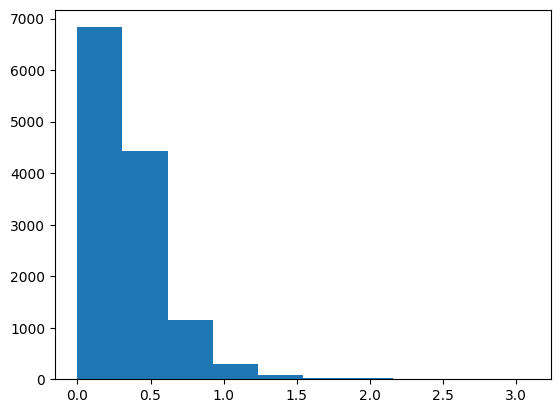

In [47]:
plt.hist(session_length_yad_feature["sess_length_var_yad"])

In [45]:
session_length_yad_feature.write_parquet("../data/features/session_length_each_yad.parquet")